In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from practica_03 import solve_root


# Ejercicio 1
## Implementar el siguiente algoritmo para hallar la raíz de una función $f$ en un intervalo real $I=[a,b]$ 

### Comienza en $x_0 = \frac{(a+b)}{2}$, el $x_{n+1}$ es el de Newton Raphson. En el caso en que $x_{n+1}$ caiga en el intervalo deseado.

### En caso contrario usar bisección.

### Recordar en cada paso redefinir el intervalo $I$ en el que hay raíz.

$\qquad$ Poniendo como ejemplo la función:

$$f(x) = x^3 - 6x^2 +4 *x + 12 $$

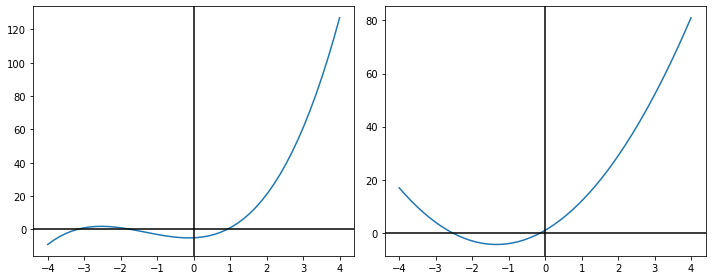

In [3]:
def f(x):
    return x**3 + 4 * x**2 + x - 5

def df(x):
    return 3 * x**2 + 8 * x + 1

x_range = np.linspace(-4,4,50)

y = [f(x) for x in x_range]
dy = [df(x) for x in x_range]

fig = plt.figure(figsize=(10, 4)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[0.2, 0.2]) 
ax1 = plt.subplot(gs[0])
ax1.plot(x_range, y)
ax2 = plt.subplot(gs[1])
ax2.plot(x_range, dy)

ax1.axhline(0, color='black')
ax1.axvline(0, color='black')
ax2.axhline(0, color='black')
ax2.axvline(0, color='black')

plt.tight_layout()


### Ejecutamos el algoritmo, pasando los rangos estimados de cada raíz para verificar que encuentra cada una de ellas.

In [4]:
for (a, b) in [(-4, -3), (-2, -1), (0, 2)]:
    # Funciones en practica_03.py
    root = solve_root(f, df, a, b, 10, xtol=1e-14)
    print(f"resultado a={a} b={b} root={root} f({root})={f(root)}")

resultado a=-4 b=-3 root=-3.198691243515997 f(-3.198691243515997)=5.329070518200751e-15
resultado a=-2 b=-1 root=-1.7135379349683995 f(-1.7135379349683995)=8.881784197001252e-16
resultado a=0 b=2 root=0.9122291784843966 f(0.9122291784843966)=0.0


# Ejercicio 2
## Un modelo de probabilidades de default: Extended CreditGrades Model with Stochastic Volatility and Jumps

### Implementar el modelo Double-Exponential Jump Difusion (DEJD) para calcular precios de una call-option y probabilidades de default (pg. 11 y pg. 13)
### Para simplificar tomar t = 0. 
### Usar el modelo para estimar precios de call y probabilidades de default de General Motors (usar los parámetros de la pg. 20). 
### Graficar los precios de call y las probabilidades de default en función del tiempo (T).





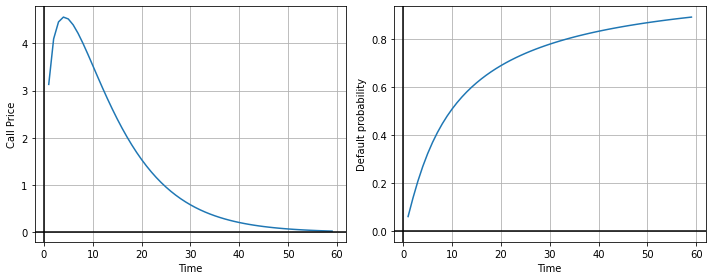

In [5]:
from dejd import DEJD

gm_model = DEJD(
    ni_inf=0.0151,
    ni_cero=0.0260,
    k_v=1.2433,
    eta_mas=0.0443,
    eta_menos=0.1181,
    q_mas=0.4894,
    lamda=162.5382
)

gm_model.set_empresa(
    nombre='General Motors',
    S_cero=25.86,
    d=0.078,
    D_cero=32.5,
    r=0.01,
    R=0.5
)

gm_model.set_root_finding_properties("brentq", 1e-30, 1000000)

tiempo = [t for t in range(1, 60)]

precio_call = [gm_model.solve_stock_price(t) for t in tiempo]
probabilidad_survival = [(1 - gm_model.solve_survival(t)) for t in tiempo]

# Ploteo
fig = plt.figure(figsize=(10, 4)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[0.2, 0.2]) 
ax1 = plt.subplot(gs[0])
ax1.plot(tiempo, precio_call)
ax2 = plt.subplot(gs[1])
ax2.plot(tiempo, probabilidad_survival)

ax1.axhline(0, color='black')
ax1.axvline(0, color='black')
ax2.axhline(0, color='black')
ax2.axvline(0, color='black')

ax1.set_ylabel("Call Price")
ax1.set_xlabel("Time")
ax1.grid()

ax2.set_ylabel("Default probability")
ax2.set_xlabel("Time")
ax2.grid()

plt.tight_layout()


### Para encontrar las raíces usar diferentes tolerancias (xtol) y los siguiente algoritmos de root finding:
* scipy.optimize.brentq
* scipy.optimize.bisect
* usando el algorirmo del item 1

### En todos los casos, calcular el tiempo que tarda el algoritmo para llegar a la raíz deseada.


Valores obtenidos para el Condicional de la matriz A que se utiliza para obtener coeficientes
  Medidas     Valores
0     min   28.279347
1     avg   74.982665
2     max  205.172990

Por lo que se puede ver de los valores obtenidos, el promedio mantiene un valor bajo y el máximo se encuentra en un orden de magnitud mayor.
Dependiendo de con que precisión queramos trabajar, un valor entre 0 y 99 nos da un dígito significativo de error, y un valor entre 100 y 999 nos aumenta a dos dígitos significativos de error.


Valores de tiempos promedios para cada método, función y tolerancia
Metodo                            bisect    brentq    manual
Tipo                Tolerancia                              
call price          10^{-06}    0.000178  0.000100  0.000380
                    10^{-07}    0.000211  0.000093  0.000367
                    10^{-08}    0.000219  0.000148  0.000430
                    10^{-09}    0.000232  0.000117  0.000432
                    10^{-10}    0.000233  0.000

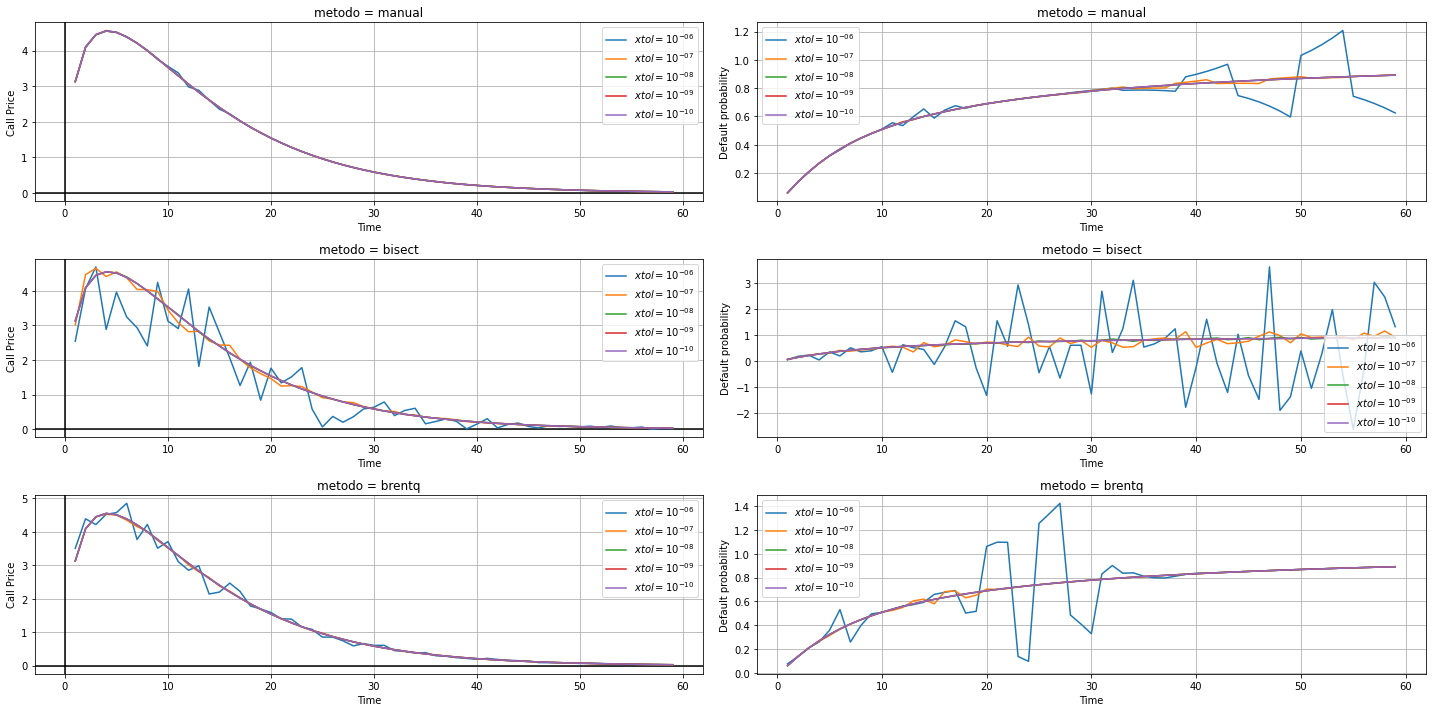

In [6]:
tiempo = [t for t in range(1, 60)]

fig = plt.figure(figsize=(20, 10)) 
gs = gridspec.GridSpec(3, 2, width_ratios=[0.2, 0.2]) 

subplots = [
    [plt.subplot(gs[0]), plt.subplot(gs[1])],
    [plt.subplot(gs[2]), plt.subplot(gs[3])],
    [plt.subplot(gs[4]), plt.subplot(gs[5])]]

row = 0

total_avg_stock = []
total_avg_prob = []

metodo = []
tolerancia = []
tipo = []
tiempo_prom = []
cond_num = []

for method in ("manual", "bisect", "brentq"):
    subplots[row][0].axhline(0, color='black')
    subplots[row][0].axvline(0, color='black')

    subplots[row][0].set_title("metodo = " + method)
    subplots[row][0].set_ylabel("Call Price")
    subplots[row][0].set_xlabel("Time")
    subplots[row][0].grid()
    
    subplots[row][1].set_title("metodo = " + method)
    subplots[row][1].set_ylabel("Default probability")
    subplots[row][1].set_xlabel("Time")
    subplots[row][1].grid()
    
    for tol in [(1e-6, "10^{-06}"), (1e-7, "10^{-07}"), (1e-8, "10^{-08}"), (1e-9, "10^{-09}"), (1e-10, "10^{-10}")]:
        gm_model.set_root_finding_properties(method=method, max_iter=10000, tol=tol[0])
        stock_val = []
        prob_val = []
        total_avg_stock = []
        total_avg_prob = []
        total_cond_stock = []

        for t in tiempo:
            stock_val.append(gm_model.solve_stock_price(t))
            total_avg_stock.extend(gm_model.root_finding_benchmark)
            total_cond_stock.extend(gm_model.conditional_number)
            prob_val.append(1 - gm_model.solve_survival(t))
            total_avg_prob.extend(gm_model.root_finding_benchmark)

        
        subplots[row][0].plot(tiempo, stock_val, label="$" + "xtol = " + tol[1] + "$")
        subplots[row][1].plot(tiempo, prob_val, label="$" + "xtol = " + tol[1] + "$")

        metodo.append(method)
        tolerancia.append(tol[1])
        tipo.append("call price")
        tiempo_prom.append(np.average(total_avg_stock))
        cond_num.append(np.average(total_cond_stock))

        metodo.append(method)
        tolerancia.append(tol[1])
        tipo.append("default probability")
        tiempo_prom.append(np.average(total_avg_prob))

    subplots[row][1].legend()
    subplots[row][0].legend()
    row = row + 1    

list_entradas = ["min", "avg", "max"]
list_valores = [np.min(total_cond_stock), np.average(total_cond_stock), np.max(total_cond_stock)]

""" https://docplayer.es/34249833-3-3-numero-de-condicion-de-una-matriz.html
"""

df_cn = pd.DataFrame(
    list(zip(list_entradas, list_valores)),
    columns=['Medidas', 'Valores']
)

print("Valores obtenidos para el Condicional de la matriz A que se utiliza para obtener coeficientes")
print(df_cn)
print("")
print("Por lo que se puede ver de los valores obtenidos, el promedio mantiene un valor bajo y el máximo se encuentra en un orden de magnitud mayor.")
print(f"Dependiendo de con que precisión queramos trabajar, un valor entre 0 y 99 nos da un dígito significativo de error, y un valor entre 100 y 999 nos aumenta a dos dígitos significativos de error.")
print("")

df = pd.DataFrame(
    list(zip(metodo, tipo, tolerancia, tiempo_prom)),
    columns=['Metodo', 'Tipo', 'Tolerancia', 'tiempo']
)

df_p = df.pivot_table('tiempo', ['Tipo', 'Tolerancia'], 'Metodo')

print("")
print("Valores de tiempos promedios para cada método, función y tolerancia")
print(df_p)
print("")

plt.tight_layout()


### Para cada algoritmo y tolerancia decidir si el modelo es confiable.
### ¿Con qué root fnding y xtol conviene implementar el algoritmo?

#### Analizando la tabla de tiempos promedios y los gráficos por función, método y tolerancia podemos realizar las siguientes observaciones:

* Cómo era esperado, el cálculo de probabilidad al utilizar solo dos raíces, el tiempo empleado es aproximadamente mitad del de precio de la call.
* Precio de Call
    * Método Manual
        * Para una tolerancia de 1e-06 el modelo ya se muestra confiable y los tiempos no varian tanto al aumentar la tolerancia.
    * Método Bisect
        * Para una tolerancia de 1e-08 ya se muestra confiable.
    * Método Brentq
        * El método brentq es el que mejores tiempos ha arrojado y con una tolerancia 1e-07 ya se muestra confiable.

    * Lo curioso es que el método implementado (newton_raphson), si bien es el peor en performance, tiene un buen factor de confianza para bajos valores de tolerancia, que, comparado contra el bisect se logra a partir de una tolerancia de 1e-8

* Probabilidad de Default
    * Método Manual
        * Para una tolerancia de 1e-07 el modelo ya se muestra confiable y los tiempos no varian tanto al aumentar la tolerancia.
    * Método Bisect
        * Para una tolerancia de 1e-08 ya se muestra confiable.
    * Método Brentq
        * El método brentq es el que mejores tiempos ha arrojado y con una tolerancia 1e-08 ya se muestra confiable.

#### A los efectos de este caso particular, utilizando el metodo brentq y una tolerancia de 1e-7 (si no es necesaria tanta precisión, aunque en diferentes pruebas, en ocasiones el 1e-10 tiene incluso tiempos mejores que 1e-7)

# Ejercicio 3

## Modelos Estadísticos: Polynomial Regression

### En el archivo Auto.csv se encuentran información de autos entre ellas las columnas mpg y horsepower.
### Usar polynomial regression de grado 1 a 5 para estimar mpg en función de horsepower. 
### ¿Cuál modelo es mejor y por qué?


In [7]:
""" Referencias
https://www.youtube.com/watch?v=H8kocPOT5v0&ab_channel=NeuralNine
https://data36.com/polynomial-regression-python-scikit-learn/
https://www.youtube.com/watch?v=SSmpyoIdJTc&ab_channel=FinancialProgrammingwithRitvik
https://stackoverflow.com/questions/47442102/how-to-find-the-best-degree-of-polynomials
"""
csv_file = pd.read_csv('Auto.csv')
csv_file.tail()


,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
387,27.0,4,140.0,86,2790,15.6,82,1,ford mustang gl
388,44.0,4,97.0,52,2130,24.6,82,2,vw pickup
389,32.0,4,135.0,84,2295,11.6,82,1,dodge rampage
390,28.0,4,120.0,79,2625,18.6,82,1,ford ranger
391,31.0,4,119.0,82,2720,19.4,82,1,chevy s-10


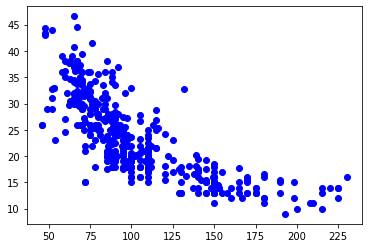

In [8]:
df = pd.DataFrame()
df['mpg'], df['horsepower'] = csv_file['mpg'], csv_file['horsepower']

plt.scatter(df['horsepower'], df['mpg'], color='b')
plt.show()

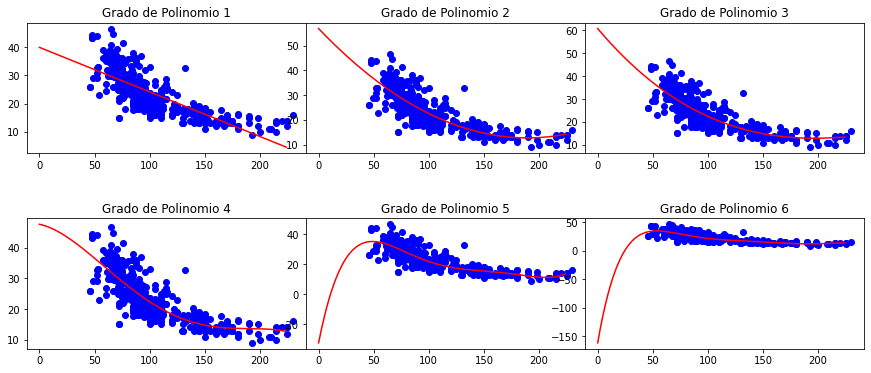

In [9]:
x = df[['horsepower']]
y = df[['mpg']]

x_predicted = []
y_predicted = []

rmses = []
min_rmse, min_deg = 1e10, 0

fig, axs = plt.subplots(2,3, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

degrees = np.arange(1, 7)

for deg in degrees:
    poly = PolynomialFeatures(degree=deg, include_bias=False)
    x_poly = poly.fit_transform(x.values)

    l_reg = LinearRegression()
    l_reg.fit(x_poly, y)

    x_vals = np.linspace(0, 224, 392).reshape(-1, 1)
    x_vals_poly = poly.transform(x_vals)
    y_axis = l_reg.predict(x_vals_poly)

    l_reg.fit(x_poly, y)

    axs[deg-1].scatter(x, y, color='b')
    axs[deg-1].plot(x_vals, y_axis, color='r')
    axs[deg-1].set_title("Grado de Polinomio " + str(deg))

    poly_mse = mean_squared_error(y, y_axis)
    poly_rmse = np.sqrt(poly_mse)
    rmses.append(poly_rmse)

    # Cross-validation of degree
    if min_rmse > poly_rmse:
        min_rmse = poly_rmse
        min_deg = deg

### Una forma de ver que tan bien un modelo de regresión aproxima a los datos es calculando la **Raíz del error cuadrático medio** (RMSE en inglés), la cuál es una métrica que nos dice, en promedio que distancia hay entre los valores de la función de regresión y los valores del modelo. Mientras más bajo es este valor, mejor aproxima la función al modelo

El gr(P)=5 es el que tiene menor RMSE=15.736026832315588


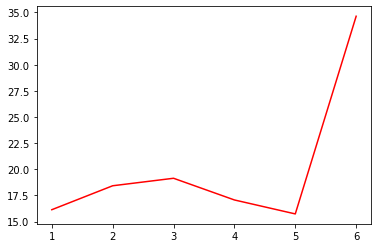

In [10]:
print(f'El gr(P)={min_deg} es el que tiene menor RMSE={min_rmse}')

plt.plot(degrees, rmses, color='r')

In [50]:
from sklearn.model_selection import cross_val_score, KFold

x = df[['horsepower']]
y = df[['mpg']]

df_score = pd.DataFrame()

degrees = np.arange(1, 7)

def armar_reporte(df, deg, score):
    df_temp = pd.DataFrame({
        "dregee": [deg],
        "score_1": [score[0]],
        "score_2": [score[1]],
        "score_3": [score[2]],
        "score_4": [score[3]],
        "score_5": [score[4]],
        "score_min": [max(score)],
        "score_avg": [score.mean()]
    })
     
    df = pd.concat([df, df_temp])
    return df

for deg in degrees:
    poly = PolynomialFeatures(degree=deg, include_bias=False)
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
    x_poly = poly.fit_transform(x_train)

    poly = LinearRegression()
    kf = KFold(n_splits=5)
    score = cross_val_score(poly, x_test, y_test, scoring="neg_root_mean_squared_error", cv=kf)

    df_score = armar_reporte(df_score, deg, score)
    
df_score

,dregee,score_1,score_2,score_3,score_4,score_5,score_min,score_avg
0,1,-4.830279,-4.782163,-5.146622,-4.448727,-4.594784,-4.448727,-4.760515
0,2,-4.830279,-4.782163,-5.146622,-4.448727,-4.594784,-4.448727,-4.760515
0,3,-4.830279,-4.782163,-5.146622,-4.448727,-4.594784,-4.448727,-4.760515
0,4,-4.830279,-4.782163,-5.146622,-4.448727,-4.594784,-4.448727,-4.760515
0,5,-4.830279,-4.782163,-5.146622,-4.448727,-4.594784,-4.448727,-4.760515
0,6,-4.830279,-4.782163,-5.146622,-4.448727,-4.594784,-4.448727,-4.760515
